# Fourier Shell Correlation with a single image stack

Ideally for FRC/FSC analysis one would have two independent observations of the region-of-interest. With 3D stacks, if only using a single detector, such a requirement is not very practical -- as acquiring two stacks will double the acquisition time and increase photobleaching. Also there's a plethora of existing image datasets on most researchers hard drives that might be of interest to analayse. 

For these reason I wanted to see if it would be possible to get a reasonable resolution estimate from a single stack only, by splitting it into two sub-stacks. 

In [126]:
%matplotlib inline
from ipywidgets import interact, fixed
import numpy as np 
import os
import supertomo.ui.frc_options as options
from supertomo.ui.plots.image import display_2d_images
from supertomo.data.io import read
import supertomo.processing.image as imops
import supertomo.data.iterators.fourier_shell_iterators as iterators
import supertomo.analysis.resolution.analysis as fsc_analysis
import supertomo.processing.windowing as windowing
from supertomo.data.containers.image import Image
import supertomo.analysis.resolution.fourier_ring_correlation as frc
from supertomo.data.containers.fourier_correlation_data import FourierCorrelationDataCollection

from supertomo.data.io.write import image as imwrite




def show_axial_slice(image1, image2, slice):
    display_2d_images(image1[slice], image2[slice])

## Data

A single 3D stack of a pollen sample was acquired with a Nikon A1 confocal microscope. First the dataset was resampled to isotropic spacing and zero padded to a cube -- after which it was split in two by using a checkerboard pattern. 

In [127]:
# Image
data_dir = "/Users/sami/Documents/Work/Data/2018_05_FSC_paper/STED_FRC_Turku_06_2018"
image1_name = "Tubulin_STED_8bit_0_a.tif"
image2_name = "Tubulin_STED_8bit_0_b.tif"

# Output Directory
directory = "/Users/sami/Documents/Work/Article manuscripts/2018_FRC:FSC/Data/Figure_FSC_Deconvolution/"



# Get script options
args_list = [data_dir, '--bin-delta=8', '--frc-curve-fit-degree=4', 
            '--resolution-threshold-criterion=snr', '--resolution-snr-value=0.5', '--use-splines']
args = options.get_frc_script_options(args_list)

# Get image
image1 = read.get_image(os.path.join(data_dir, image1_name), channel=0)
image2 = read.get_image(os.path.join(data_dir, image2_name), channel=0)

z_correction = image1.spacing[0]/image1.spacing[1]
#z_correction = 1
# Pre-process
#image = imops.zoom_to_isotropic_spacing(image, order=0)
#image = imops.zero_pad_to_cube(image)
image1 = imops.crop_to_shape(image1, [30,300,300])
image2 = imops.crop_to_shape(image2, [30,300,300])


#image1, image2 = imops.checkerboard_split(image)

#image1 = Image(windowing.apply_hamming_window(image1), image1.spacing)
#image2 = Image(windowing.apply_hamming_window(image2), image2.spacing)


print image1.shape, image1.dtype

(30, 300, 300) uint8


The zoom is [3.3, 1.0]
The zoom is [3.3, 1.0]


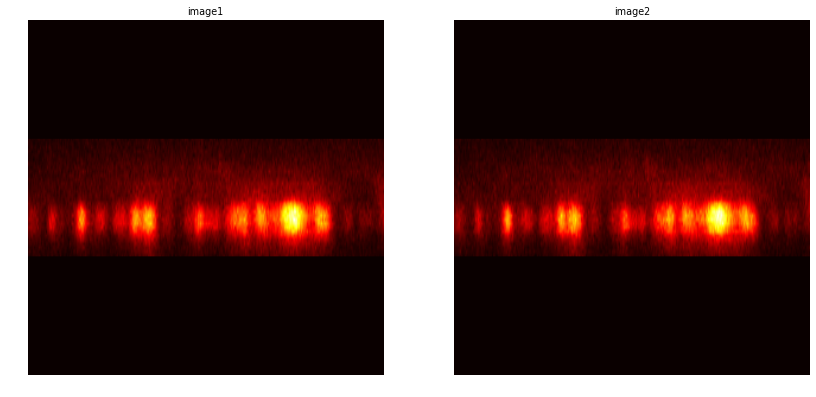

In [128]:
image1_xz = Image(image1[:,254,:], image1.spacing[:-1])
image2_xz = Image(image2[:,254,:], image2.spacing[:-1])



image1_xz = imops.zoom_to_isotropic_spacing(image1_xz, order=1)
image2_xz = imops.zoom_to_isotropic_spacing(image2_xz, order=1)


image1_xz = imops.zero_pad_to_cube(image1_xz)
image2_xz = imops.zero_pad_to_cube(image2_xz)


display_2d_images(image1_xz, image2_xz)

imwrite(os.path.join(directory, "tubulin_xz.tif"), image1_xz)


#image = imops.zero_pad_to_cube(image)

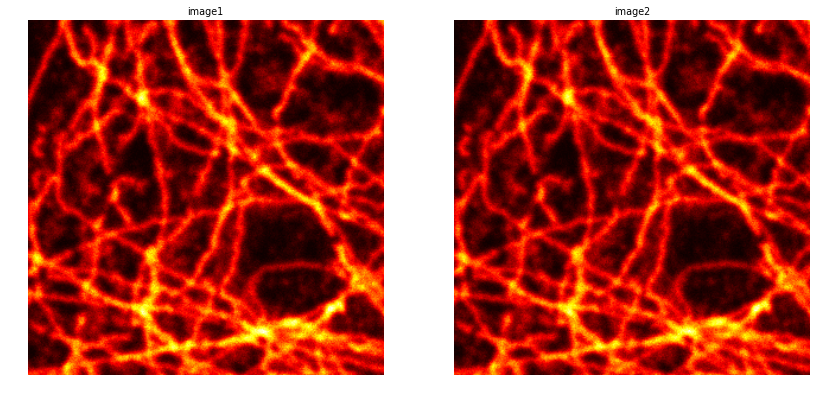

In [129]:
image1_xy = Image(image1[20], image1.spacing[1:])
image2_xy = Image(image2[20], image2.spacing[1:])

imwrite(os.path.join(directory, "tubulin_xy.tif"), image1_xy)



display_2d_images(image1_xy, image2_xy)




In [130]:
data = FourierCorrelationDataCollection()

frc_task_xz = frc.FRC(image1_xz, image2_xz, args.d_bin)
data[90] = frc_task_xz.execute()

frc_task_xy = frc.FRC(image1_xy, image2_xy, args.d_bin)
data[0] = frc_task_xy.execute()


In [131]:
from math import sqrt

analyzer = fsc_analysis.FourierCorrelationAnalysis(data, image1_xz.spacing[0], args)
results = analyzer.execute(z_correction=z_correction)

Fit starts at 0.266666680574
Optimization terminated successfully.
         Current function value: 0.000041
         Iterations: 9
         Function evaluations: 18
Fit starts at 0.426666676998
Optimization terminated successfully.
         Current function value: 0.000042
         Iterations: 9
         Function evaluations: 18


## Results

The results look correct, but I am not sure about the numerical values, as I don't know the NA exactly.

$r_{xy} =  \frac{ 0.6 \lambda}{{NA}}$

$r_{z} = \frac{1.4 \lambda \eta}{{NA}^2} $

I'm going to confirm manually by line profile measurements.

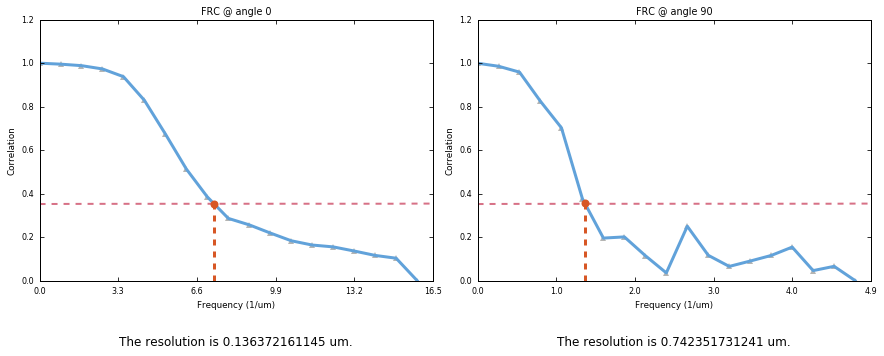

In [132]:
import supertomo.ui.plots.frc as frcplots


plotter = frcplots.FourierDataPlotter(results, directory)
plotter.plot_all()

In [133]:

#plotter.plot_one_to_file(0, "frc_tubulin_0")

#plotter.plot_one_to_file(90, "frc_tubulin_90", coerce_ticks=False)

# 